In [3]:
#!pip install -q nltk pycountry sentence-transformers
!pip install -q pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.3 MB/s eta 0:00:00:00:010:01


In [4]:
from tensorflow.keras.utils import to_categorical
import gc
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import pycountry
import string
import pandas as pd
import random
import nltk
from nltk.corpus import wordnet
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models, callbacks, regularizers
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

# 1. Data Collection

In [4]:
!git clone -n --depth=1 --filter=tree:0 \
  https://github.com/CoronaNetDataScience/corona_tscs

!cd corona_tscs && git sparse-checkout set --no-cone /data/CoronaNet/data_country/coronanet_release && git checkout

Cloning into 'corona_tscs'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1 (delta 0), reused 1 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (1/1), done.
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 0), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 19.90 KiB | 384.00 KiB/s, done.
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 201 (delta 37), reused 1 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (201/201), 27.02 MiB | 1.97 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (201/201), done.
Your branch is up to date with 'origin/master'.


In [5]:
dfs = []
for csv in os.listdir('corona_tscs/data/CoronaNet/data_country/coronanet_release'):
    # read each csv into a separate dataframe
    df = pd.read_csv(os.path.join('corona_tscs/data/CoronaNet/data_country/coronanet_release', csv), low_memory=False)
    dfs.append(df)

big_frame = pd.concat(dfs, ignore_index=True)

In [6]:
big_frame.shape

(200486, 68)

In [7]:
big_frame.columns

Index(['record_id', 'policy_id', 'entry_type', 'update_type', 'update_level',
       'update_level_var', 'description', 'date_announced', 'date_start',
       'date_end', 'date_end_spec', 'country', 'ISO_A3', 'ISO_A2',
       'init_country_level', 'domestic_policy', 'province', 'ISO_L2', 'city',
       'type', 'type_sub_cat', 'type_new_admin_coop', 'type_vac_cat',
       'type_vac_mix', 'type_vac_reg', 'type_vac_purchase', 'type_vac_group',
       'type_vac_group_rank', 'type_vac_who_pays', 'type_vac_dist_admin',
       'type_vac_loc', 'type_vac_cost_num', 'type_vac_cost_scale',
       'type_vac_cost_unit', 'type_vac_cost_gov_perc', 'type_vac_amt_num',
       'type_vac_amt_scale', 'type_vac_amt_unit', 'type_vac_amt_gov_perc',
       'type_text', 'institution_cat', 'institution_status',
       'institution_conditions', 'target_init_same', 'target_country',
       'target_geog_level', 'target_region', 'target_province', 'target_city',
       'target_intl_org', 'target_other', 'target_who

In [8]:
df = big_frame[["description", "type"]].drop_duplicates(subset=['description']).reset_index(drop=True)
del dfs, big_frame
gc.collect()

0

# Data Augmentation

In [9]:

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lem in syn.lemmas():
            if lem.name().lower() != word.lower():
                synonyms.add(lem.name().replace("_", " "))
    return list(synonyms)

def synonym_replacement(sentence, n=1):
    words = sentence.split()
    if len(words) < 2:
        return sentence

    candidates = [w for w in words if get_synonyms(w)]
    if not candidates:
        return sentence

    for _ in range(n):
        word = random.choice(candidates)
        synonym = random.choice(get_synonyms(word))
        words = [synonym if w == word else w for w in words]

    return " ".join(words)

def random_deletion(sentence, p=0.1):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = [w for w in words if random.random() > p]
    return " ".join(new_words) if new_words else random.choice(words)

def random_swap(sentence, n=1):
    words = sentence.split()
    if len(words) < 2:
        return sentence

    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]

    return " ".join(words)

def augment_text(text):
    choice = random.choice(["synonym", "swap", "delete"])

    if choice == "synonym":
        return synonym_replacement(text, n=1)
    elif choice == "swap":
        return random_swap(text, n=1)
    elif choice == "delete":
        return random_deletion(text, p=0.15)

    return text

In [10]:
class_counts = df["type"].value_counts()
max_count = class_counts.max()

augmented_rows = []

for label, count in class_counts.items():
    subset = df[df["type"] == label]
    needed = max_count - count

    if needed > 0:
        for i in range(needed):
            row = subset.sample(1).iloc[0]
            new_desc = augment_text(row["description"])
            augmented_rows.append({"description": new_desc, "type": label})

aug_df = pd.DataFrame(augmented_rows)

In [11]:
df = shuffle(pd.concat([df, aug_df], ignore_index=True), random_state=42)

## 2. Preprocess Data

In [12]:
# Combine all preprocessing steps

# Initialize stop_words and lemmatizer globally for efficiency
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):

    # 1. Convert text to lowercase
    def to_lower(text):
        return text.lower()

    # 2. Remove punctuation and numbers
    def remove_punctuation_numbers(text):
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\b(\d+)(st|nd|rd|th)\b', '', text)  # Remove Ordered Numbering
        text = re.sub(r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:t(?:ember)?)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\b', '', text)
        return text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # 3. Tokenize text into words
    def tokenize(text):
        return nltk.word_tokenize(text)

    # 4. Modified remove_stopwords function: now operates on a list of tokens
    def remove_stopwords(tokens):
        return [word for word in tokens if word not in stop_words]

    # 5. Apply lemmatization to reduce words to their base (dictionary) form
    def apply_lemmatization(tokens):
        return [lemmatizer.lemmatize(word) for word in tokens]

    text = to_lower(text)
    text = remove_punctuation_numbers(text)

    # Original country removal logic, now applied to the string before tokenization
    for c in pycountry.countries:
        # Using re.escape for robustness against special characters in country names
        text = re.sub(r'\b' + re.escape(c.name.lower()) + r'\b', '', text)

    tokens = tokenize(text) # Tokenize the cleaned string
    tokens = remove_stopwords(tokens) # Call the modified remove_stopwords with tokens
    tokens = apply_lemmatization(tokens) # Apply lemmatization to the tokens
    return " ".join(tokens)

# 6- Apply Preprocessing
df["description"] = df["description"].apply(preprocess_text)

# Modelling

#### Label encoding

#### Split train-test sets

In [4]:
!pip install -q pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 112.4 MB/s eta 0:00:0000:01


In [5]:
from tensorflow.keras.utils import to_categorical;import gc;import os;from nltk.corpus import stopwords;from nltk.stem import WordNetLemmatizer;import re;import pycountry;import string;import pandas as pd;import random;import nltk;from nltk.corpus import wordnet;from sklearn.utils import shuffle;import tensorflow as tf;from sklearn.model_selection import train_test_split;from sklearn.preprocessing import LabelEncoder;from sklearn.metrics import classification_report;from tensorflow.keras import layers, models, callbacks, regularizers;import numpy as np;from sentence_transformers import SentenceTransformer;import matplotlib.pyplot as plt;import seaborn as sns;from sklearn.metrics import confusion_matrix

df = pd.read_csv('/kaggle/input/corona-articles-dataset/data.csv')

In [6]:
type_mapping = {"Hygiene": "Health","Health Monitoring": "Health","Health Testing": "Health","COVID-19 Vaccines": "Health","Health Resources": "Health","Closure and Regulation of Schools": "Education","Quarantine": "Restrictions","Social Distancing": "Restrictions","Lockdown": "Restrictions","Curfew": "Restrictions","Internal Border Restrictions": "Restrictions",'External Border Restrictions': "Restrictions",'Restriction and Regulation of Businesses': "Restrictions","Restriction and Regulation of Government Services": "Restrictions","Restrictions of Mass Gatherings": "Restrictions","Declaration of Emergency": "Government Measures","New Task Force, Bureau or Administrative Configuration": "Government Measures","Public Awareness Measures": "Awareness","Anti-Disinformation Measures": "Awareness","Other Policy Not Listed Above": "Other"}
df['type_gen'] = df['type'].map(type_mapping)

In [7]:
# Prevent data leakage and ensures model isn't trained multiple times on the same input with possibly conflicting labels.
df = df.drop_duplicates(subset=["description"])

# 1. Encode strings to integers (String -> Int)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['type'])

label_gen_encoder = LabelEncoder()
df['label_gen'] = label_gen_encoder.fit_transform(df['type_gen'])

# 2. Split the data using the integer labels
# We use the integer labels here so 'stratify' works correctly
X_train, X_test, y_train_int, y_test_int = train_test_split(
    df['description'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

X_train_gen, X_test_gen, y_train_int_gen, y_test_int_gen = train_test_split(
    df['description'],
    df['label_gen'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_gen']
)

y_train = to_categorical(y_train_int, num_classes=len(label_encoder.classes_))
y_test = to_categorical(y_test_int, num_classes=len(label_encoder.classes_))

y_train_gen = to_categorical(y_train_int_gen, num_classes=len(label_gen_encoder.classes_))
y_test_gen = to_categorical(y_test_int_gen, num_classes=len(label_gen_encoder.classes_))

# Verification print
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_train_gen: {y_train_gen.shape}")

Shape of y_train: (243200, 20)
Shape of y_train_gen: (243200, 6)


In [8]:
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device='cuda')

def sentence_embed(text_list, model):
    """
    Takes a list of text strings and returns a matrix of sentence embeddings.
    Shape: (num_samples, embedding_dim)
    """
    # The SentenceTransformer model handles preprocessing and embedding generation internally
    embeddings = model.encode(text_list, show_progress_bar=True)
    return np.array(embeddings)

X_train_embed = sentence_embed(X_train.tolist(), sentence_model)
X_test_embed = sentence_embed(X_test.tolist(), sentence_model)

X_train_embed_gen = sentence_embed(X_train_gen.tolist(), sentence_model)
X_test_embed_gen = sentence_embed(X_test_gen.tolist(), sentence_model)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7600 [00:00<?, ?it/s]

Batches:   0%|          | 0/1901 [00:00<?, ?it/s]

Batches:   0%|          | 0/7600 [00:00<?, ?it/s]

Batches:   0%|          | 0/1901 [00:00<?, ?it/s]

In [9]:
#df.to_csv('data.csv', index=False)

In [10]:
model = models.Sequential([
    layers.Input(shape=(384,), dtype=tf.float32),

    # First dense block
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),

    # Second dense block
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    # Third dense block
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Fourth dense block
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile with a lower initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.35, patience=3, min_lr=1e-8, verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_embed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

I0000 00:00:1765282623.180010      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15143 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/100


I0000 00:00:1765282626.658556     139 service.cc:148] XLA service 0x7e453800dde0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765282626.659146     139 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765282626.960158     139 cuda_dnn.cc:529] Loaded cuDNN version 90300


  68/6080 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.0610 - loss: 2.9833 

I0000 00:00:1765282629.107036     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6080/6080 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.5251 - loss: 1.6154 - val_accuracy: 0.7171 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 2/100
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.6990 - loss: 1.0832 - val_accuracy: 0.7472 - val_loss: 0.8787 - learning_rate: 0.0010
Epoch 3/100
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7281 - loss: 0.9816 - val_accuracy: 0.7639 - val_loss: 0.8193 - learning_rate: 0.0010
Epoch 4/100
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7456 - loss: 0.9153 - val_accuracy: 0.7700 - val_loss: 0.7951 - learning_rate: 0.0010
Epoch 5/100
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7564 - loss: 0.8747 - val_accuracy: 0.7811 - val_loss: 0.7641 - learning_rate: 0.0010
Epoch 6/100
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7666 - loss: 0.8389 - val_accuracy: 0.7871 - val_loss: 0.7363 - learning_rate: 0.0010
Epoch 7/100
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7738 -

In [11]:
model_gen = tf.keras.Sequential([
    # Input
    layers.Input(shape=(384,), dtype=tf.float32),
    # Block 1
    layers.Dense(512, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),

    # Block 2
    layers.Dense(256, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.3),

    # Block 3

    layers.Dense(128, activation='gelu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),

    layers.Dense(6, activation='softmax')
])


model_gen.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history_gen = model_gen.fit(
    X_train_embed_gen, y_train_gen,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6882 - loss: 1.0664 - val_accuracy: 0.8170 - val_loss: 0.6901 - learning_rate: 3.0000e-04
Epoch 2/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8187 - loss: 0.6899 - val_accuracy: 0.8386 - val_loss: 0.6101 - learning_rate: 3.0000e-04
Epoch 3/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8386 - loss: 0.6140 - val_accuracy: 0.8516 - val_loss: 0.5593 - learning_rate: 3.0000e-04
Epoch 4/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8522 - loss: 0.5597 - val_accuracy: 0.8648 - val_loss: 0.5143 - learning_rate: 3.0000e-04
Epoch 5/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8639 - loss: 0.5164 - val_accuracy: 0.8748 - val_loss: 0.4793 - learning_rate: 3.0000e-04
Epoch 6/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8747 - loss: 0.4766 - val_accuracy: 0.8834 - val_loss: 0.4506 - learning_rate: 3.0000e-04
Epoch 7/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 

# Evaluation

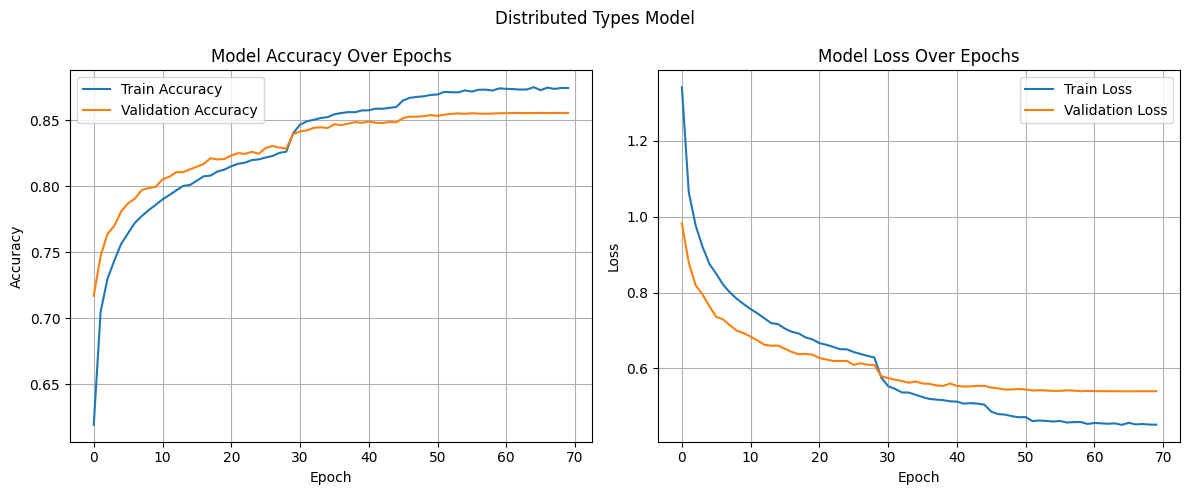

In [12]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.suptitle('Distributed Types Model')
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

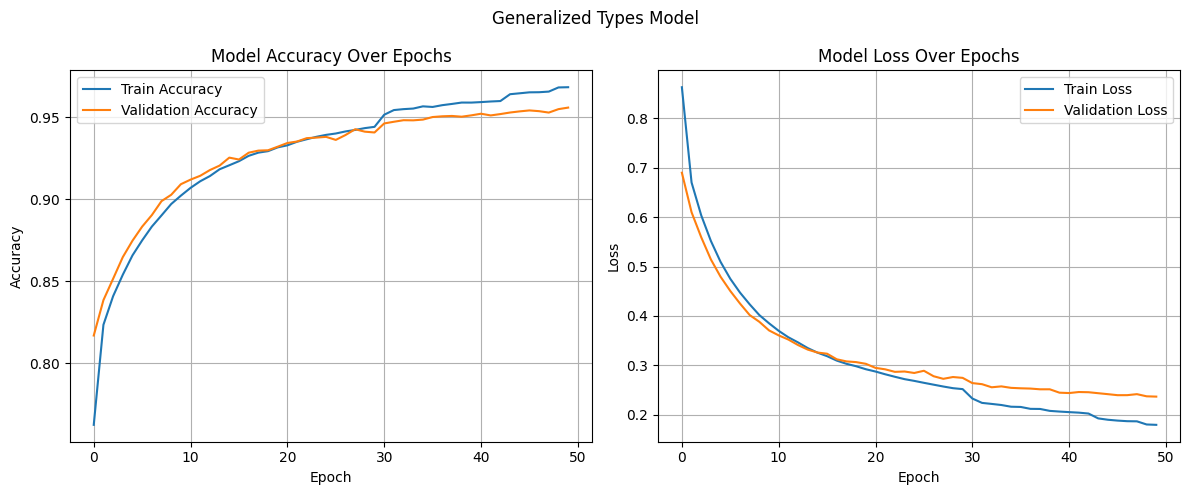

In [13]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.suptitle('Generalized Types Model')
plt.subplot(1, 2, 1)
plt.plot(history_gen.history['accuracy'], label='Train Accuracy')
plt.plot(history_gen.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_gen.history['loss'], label='Train Loss')
plt.plot(history_gen.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
y_pred = model.predict(X_test_embed)
y_pred_labels = tf.argmax(y_pred, axis=1)

print(classification_report(y_test_int, y_pred_labels, target_names=label_encoder.classes_))

1901/1901 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
                                                        precision    recall  f1-score   support

                          Anti-Disinformation Measures       0.97      0.98      0.98      2904
                                     COVID-19 Vaccines       0.90      0.97      0.93      2969
                     Closure and Regulation of Schools       0.91      0.95      0.93      3121
                                                Curfew       0.94      0.96      0.95      2845
                              Declaration of Emergency       0.96      0.96      0.96      2817
                          External Border Restrictions       0.83      0.78      0.81      3174
                                     Health Monitoring       0.81      0.88      0.84      3018
                                      Health Resources       0.79      0.71      0.75      3180
                                        Health Testing       0.81      0.90      0.86      3

In [18]:
y_pred_gen = model_gen.predict(X_test_embed_gen)
y_pred_labels_gen = tf.argmax(y_pred_gen, axis=1)

print(classification_report(y_test_int_gen, y_pred_labels_gen, target_names=label_gen_encoder.classes_))

1901/1901 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
                     precision    recall  f1-score   support

          Awareness       0.95      0.94      0.95      5965
          Education       0.94      0.96      0.95      3120
Government Measures       0.97      0.96      0.96      5854
             Health       0.94      0.96      0.95     15187
              Other       0.94      0.87      0.90      3030
       Restrictions       0.97      0.97      0.97     27645

           accuracy                           0.96     60801
          macro avg       0.95      0.94      0.95     60801
       weighted avg       0.96      0.96      0.96     60801



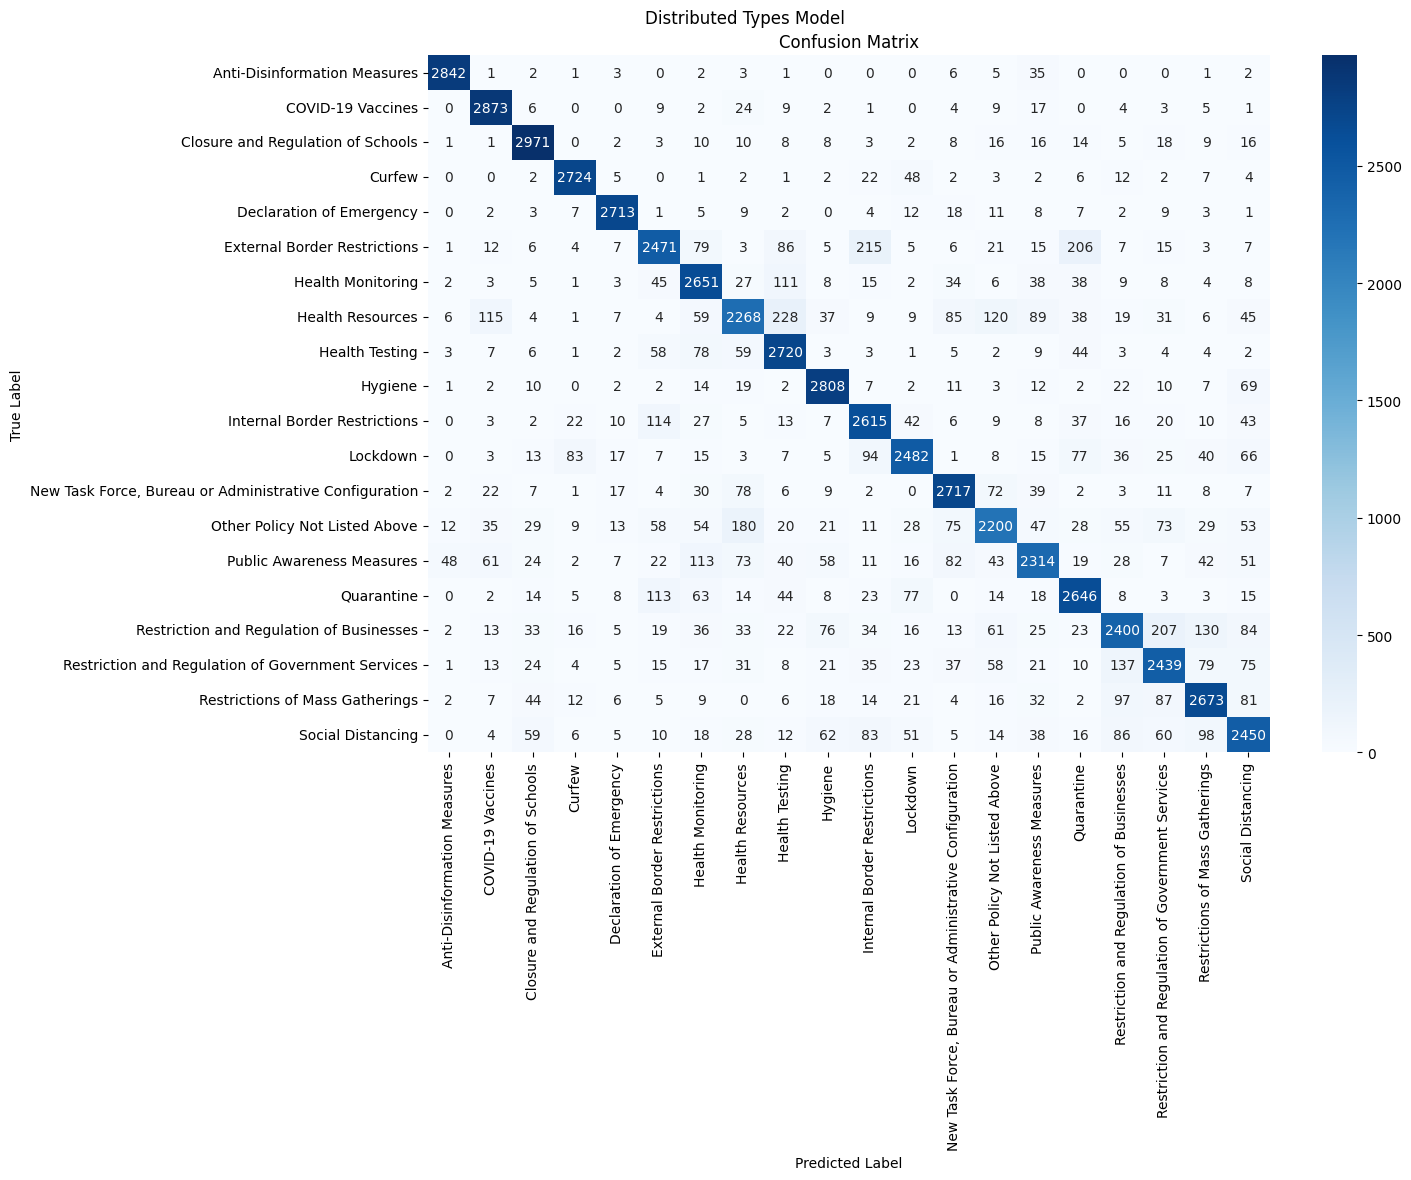

In [22]:
# Compute confusion matrix
cm = confusion_matrix(y_test_int, y_pred_labels)

# Plotting the confusion matrix
plt.figure(figsize=(15, 12))
plt.suptitle('Distributed Types Model')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

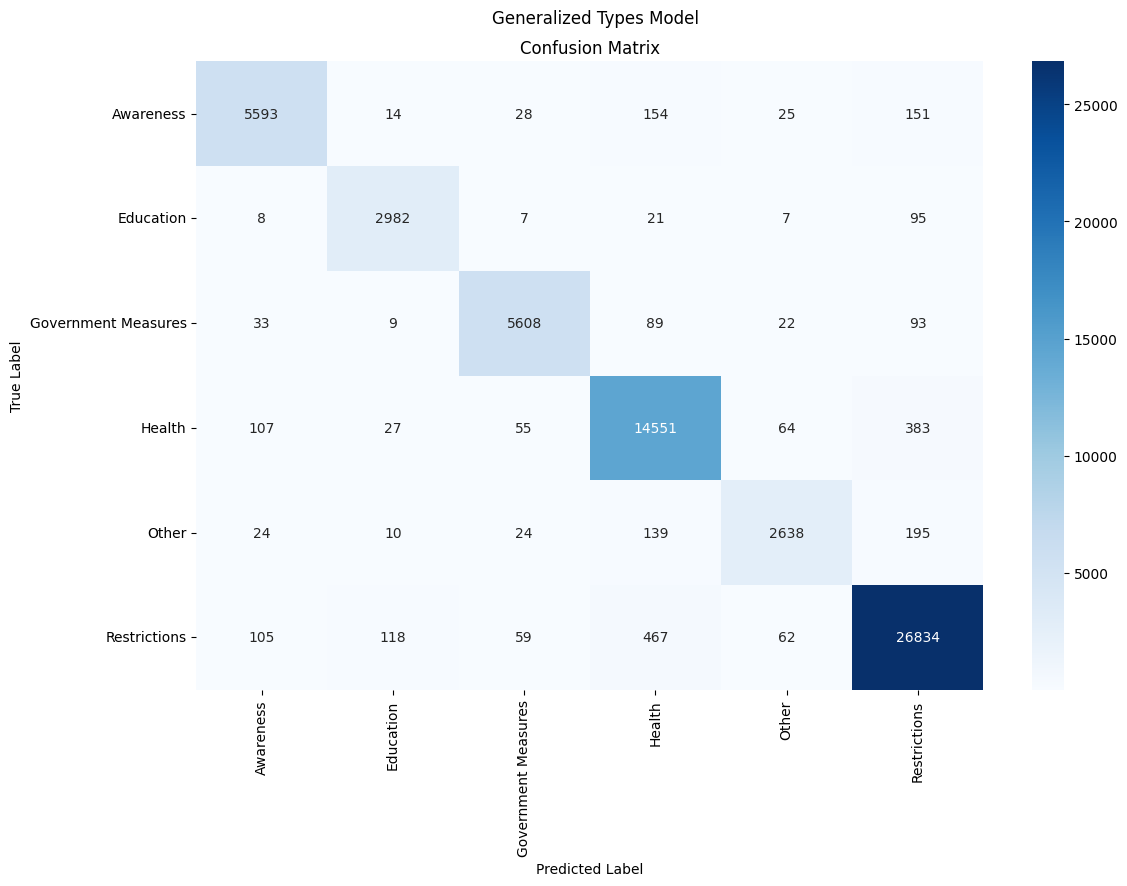

In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_test_int_gen, y_pred_labels_gen)

# Plotting the confusion matrix
plt.figure(figsize=(12, 9))
plt.suptitle('Generalized Types Model')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_gen_encoder.classes_,
            yticklabels=label_gen_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
model.save('distributed_types_20classes.keras')
model_gen.save('generalized_types_6classes.keras')